In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

from tslearn.clustering import TimeSeriesKMeans
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, \
    TimeSeriesResampler

from tslearn.clustering import silhouette_score

In [ ]:
def process_lit(path, year):
    lit=pd.read_excel(path).replace("-", 0).fillna(0)
    lit = lit.pivot(index="Semaine", columns="Code UF", values="Lits fermés moyens")
    lit['date_semaine'] = pd.date_range(start=f'{year}-01-01', periods=52, freq='W')
    lit.set_index('date_semaine', inplace=True)
    lit=lit.clip(lower=0)
    return lit

In [ ]:
lit_24= process_lit(r"C:\Stage\generated_data\lits\lit_2024.xlsx", 2024)
lit_23= process_lit(r"C:\Stage\generated_data\lits\lit_2023.xlsx", 2023)
lit= pd.concat([lit_23, lit_24], axis=0).fillna(0)
X_train = lit.T.values[:, :,np.newaxis]


In [ ]:
score=[]
n_clusters = list(range(2,11))
for i in  n_clusters:
    km = TimeSeriesKMeans(n_clusters=i, metric='dtw',random_state=0)
    y_pred = km.fit_predict(X_train)
    score.append(silhouette_score(X_train, y_pred, metric='dtw'))


plt.figure(figsize=(12,5))
plt.plot(n_clusters,score,marker='o')
plt.xlabel("Number of clusters")
plt.ylabel("silhouette score")

In [5]:
km = TimeSeriesKMeans(n_clusters=2, metric="dtw", random_state=0)
y_pred = km.fit_predict(X_train)
silhouette_score(X_train, y_pred, metric='dtw')

0.5638700587549954

In [6]:
y_pred=y_pred.reshape(1,-1)
clusters = pd.DataFrame(y_pred, columns=lit.columns)
c1= clusters.loc[0] ==1
c0 = clusters.loc[0] == 0
lit_cluster_0 = lit[lit.columns[c0].tolist()]
lit_cluster_1 = lit[lit.columns[c1].tolist()]

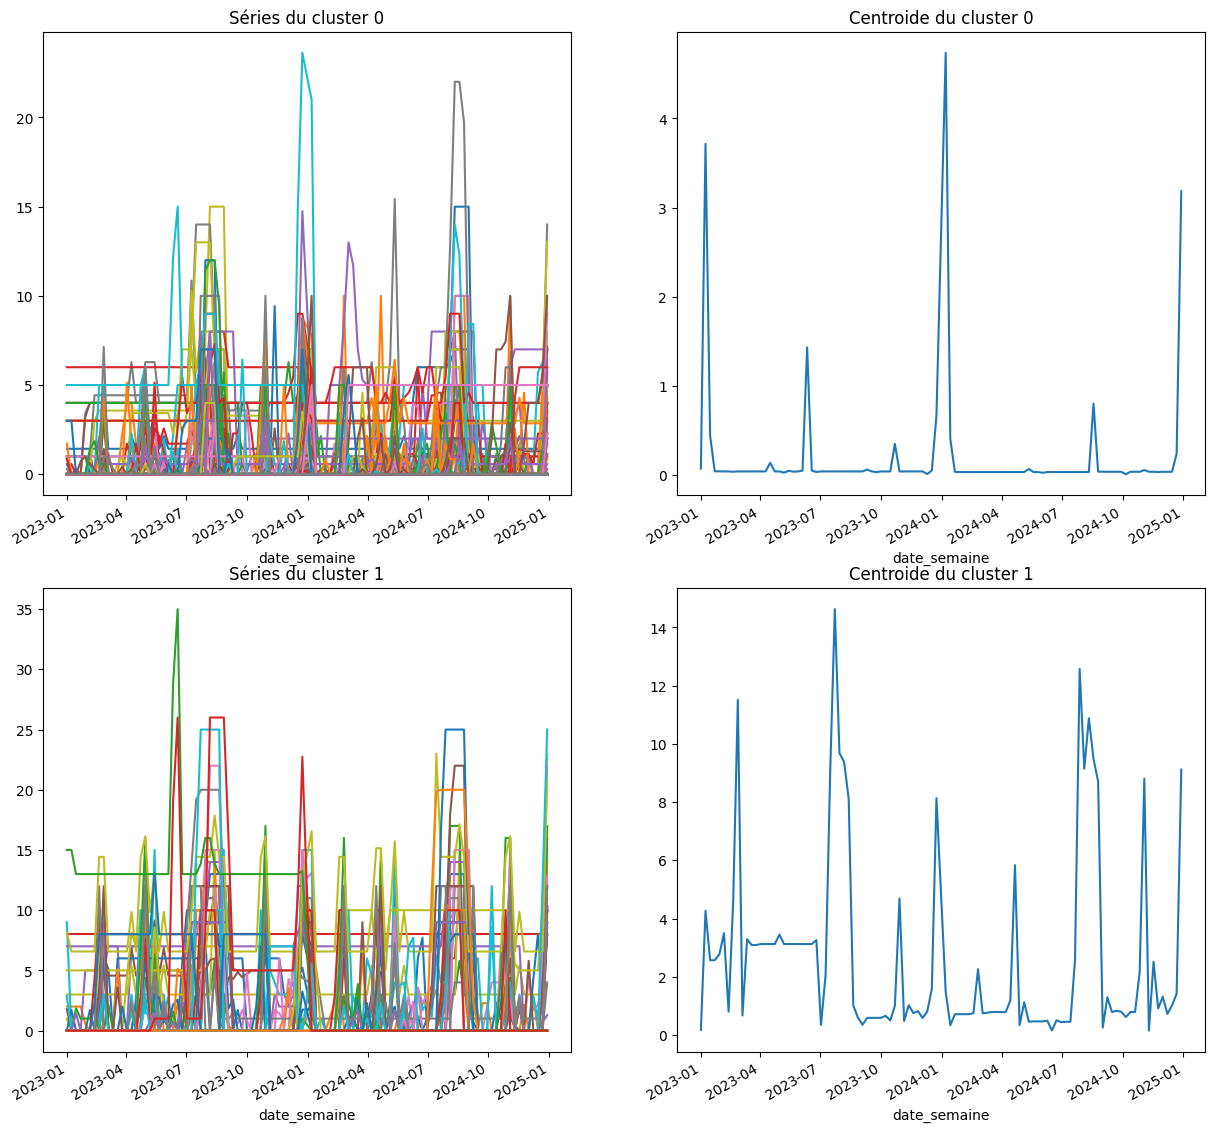

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(15, 15))

lit_cluster_0.plot(ax=axes[0,0], legend=False)
axes[0,0].set_title("Séries du cluster 0")

pd.DataFrame(km.cluster_centers_[0], index=lit.index).plot(ax=axes[0,1], legend=False)
axes[0,1].set_title("Centroide du cluster 0")

lit_cluster_1.plot(ax=axes[1, 0], legend=False)
axes[1,0].set_title("Séries du cluster 1")

pd.DataFrame(km.cluster_centers_[1], index=lit.index).plot(ax=axes[1, 1], legend=False)
axes[1,1].set_title("Centroide du cluster 1")


plt.show()


In [ ]:
correlation_matrix = lit_cluster_1.corr()

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)
upper_triangle = correlation_matrix.where(mask)
total_pairs = upper_triangle.count().sum()
high_corr_pairs = (upper_triangle > 0.5).sum().sum()
percentage = (high_corr_pairs / total_pairs) * 100
print(f"\nTotal unique pairs: {total_pairs}")
print(f"Pairs with correlation > 0.5: {high_corr_pairs}")
print(f"Percentage of pairs with correlation > 0.5: {percentage:.2f}%")


Total unique pairs: 903
Pairs with correlation > 0.5: 343
Percentage of pairs with correlation > 0.5: 37.98%
